<a href="https://colab.research.google.com/github/Haytam258/NLPDisaster/blob/main/NLPDisaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploader = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 112MB/s]


In [5]:
import zipfile 
from pathlib import Path

data_path = Path("data/")

if data_path.is_dir() :
  print("Skipping directory creation ...")
else:
  print("Creating the directory data...")
  data_path.mkdir(exist_ok = True, parents = True)
  !mv nlp-getting-started.zip data/nlp-getting-started.zip

with zipfile.ZipFile(data_path/"nlp-getting-started.zip","r") as zip_ref:
  print("Extracting data...")
  zip_ref.extractall(data_path/"nlp-getting-started")

Creating the directory data...
Extracting data...


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

train_data = pd.read_csv("data/nlp-getting-started/train.csv", index_col = "id")

train_data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_data.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


The misspellings seem to be quite intense there, as well as repetition (USA = United States = New York and Canada = Montreal), i don't even know what IIT: ... is supposed to be, so it's most likely a corrupted entry.

In [8]:
train_data.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [9]:
train_data[train_data.location == 'MontrÌ©al, QuÌ©bec']

,keyword,location,text,target
id,,,,
3723,destroyed,"MontrÌ©al, QuÌ©bec",The grenade sound effect on 'Impossible' just ...,0


Dropping the column entirely, since the column doesn't seem to hold any useful information, and it's possible that it may consider being in US as a factor for whether a tweet is disaster related or not.

In [10]:
train_data.drop(columns = "location", inplace = True)
train_data.head()

,keyword,text,target
id,,,
1,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

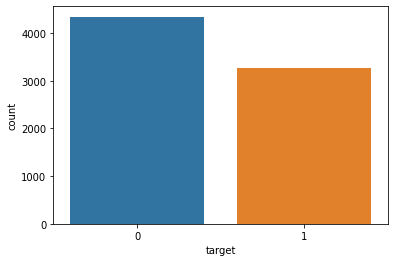

In [12]:
sns.countplot(data = train_data, x = 'target')

Keyword does hold a lot of information, but since we want to work purely with the tweets, we'll drop the keyword column.

In [13]:
train_data.groupby(by = "target")['keyword'].value_counts()

target  keyword    
0       body%20bags    40
        armageddon     37
        harm           37
        deluge         36
        ruin           36
                       ..
1       body%20bag      1
        body%20bags     1
        electrocute     1
        epicentre       1
        ruin            1
Name: keyword, Length: 438, dtype: int64

In [14]:
len(train_data)

7613

In [15]:
train_data['keyword'].isnull().values.sum()

61

In [16]:
percent_missing = train_data['keyword'].isnull().sum() / len(train_data) * 100
print(f"The percent of entries / rows missing a keyword is : {percent_missing}")

The percent of entries / rows missing a keyword is : 0.8012610009194797


After doing some discovery, it seems that there's a lot of http... something in the text, which is unrelated and therefore needs to be removed.

In [17]:
from sklearn.pipeline import Pipeline
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")
# Let's first use our TfidfVectorizer
def preprocessing_text(text):
  # Let's first remove the punctuations and make our characters lower
  text = str(text).lower()
  text = text.strip()
  translator = str.maketrans('','', string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§')
  # Remove mentions/usernames
  text = re.sub(r'@\S+', '', text)
  text = text.translate(translator)

  # Remove HTML elements
  text = re.sub('<.*?>+', '', text)

  # Remove next lines
  text = re.sub('\n', '', text)

  # We tokenize our words and make sure to remove the stopwords
  list_words = word_tokenize(text = text)

  # We remove the numbers
  list_words = [re.sub(r'\d+', "", word) for word in list_words]

  # We remove the URLs and mentions
  list_words = [re.sub(r"(?:\@|https?\://)\S+", "",word) for word in list_words]

  # Removing the Htt... words and making sure we avoid the "u" type of text
  if STOPWORDS is not None:
    list_words = [word for word in list_words if word not in STOPWORDS and "htt" not in word and len(word) > 1 and "\x89" not in word]

  # We lemmatize our words
  lematizer = WordNetLemmatizer()
  words = [lematizer.lemmatize(word) for word in list_words if len(word) > 1]
  return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
train_data["text_clean"] = train_data["text"].apply(lambda x: preprocessing_text(x))
train_data.head()

,keyword,text,target,text_clean
id,,,,
1,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
5,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
6,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [19]:
words_dict = {}
for sentence in train_data["text_clean"].values:
  for word in sentence.split(" "):
    if word not in words_dict:
      words_dict[word] = 1
    else:
      words_dict[word] += 1

words_dict

{'deed': 2,
 'reason': 30,
 'earthquake': 53,
 'may': 87,
 'allah': 8,
 'forgive': 2,
 'u': 168,
 'forest': 66,
 'fire': 347,
 'near': 54,
 'la': 29,
 'ronge': 1,
 'sask': 1,
 'canada': 13,
 'resident': 8,
 'asked': 9,
 'shelter': 6,
 'place': 31,
 'notified': 1,
 'officer': 37,
 'evacuation': 51,
 'order': 35,
 'expected': 15,
 'people': 198,
 'receive': 2,
 'wildfire': 82,
 'california': 121,
 'got': 123,
 'sent': 13,
 'photo': 65,
 'ruby': 1,
 'alaska': 6,
 'smoke': 49,
 'pours': 1,
 'school': 69,
 'rockyfire': 4,
 'update': 47,
 'hwy': 10,
 'closed': 20,
 'direction': 15,
 'due': 30,
 'lake': 16,
 'county': 38,
 'cafire': 2,
 'flood': 111,
 'disaster': 154,
 'heavy': 20,
 'rain': 52,
 'cause': 61,
 'flash': 20,
 'flooding': 50,
 'street': 32,
 'manitou': 1,
 'colorado': 16,
 'spring': 18,
 'area': 47,
 'im': 295,
 'top': 57,
 'hill': 12,
 'see': 108,
 'wood': 6,
 'there': 45,
 'emergency': 157,
 'happening': 13,
 'building': 136,
 'across': 20,
 'afraid': 5,
 'tornado': 38,
 'comin

In [20]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split


X = train_data["text_clean"]
y = train_data.target

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, random_state = 42, stratify = train_data.target)


X_train.head()

id
8902     sassy city girl country hunk stranded smoky mo...
472      god kingdom heavenly govt rule people earth ar...
1448     mopheme bigstar johnson problem game body bagg...
10407                            sound like whirlwind life
3137     malaysia confirms plane debris washed reunion ...
Name: text_clean, dtype: object

In [21]:
vectorizer_tfidf = TfidfVectorizer(max_features = None, ngram_range=(1,3))
vectorizer_tfidf.fit(X_train)

TfidfVectorizer(ngram_range=(1, 3))

In [22]:
from sklearn.linear_model import LogisticRegression
classifier_tfidf = LogisticRegression()

model = Pipeline(steps= [
    ("vectorizer", vectorizer_tfidf),
    ("classifier", classifier_tfidf)
])

model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('classifier', LogisticRegression())])

In [23]:
model.score(X_train, y_train)

0.919047619047619

In [24]:
model.score(X_test, y_test)

0.8089297439264609

In [25]:
grid = GridSearchCV(estimator = model, param_grid = {
    'classifier__C': [1, 2, 5, 10, 100]
}, cv = 5)
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 3))),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [1, 2, 5, 10, 100]})

In [26]:
grid.best_estimator_

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('classifier', LogisticRegression(C=1))])

In [27]:
grid.best_estimator_.score(X_train, y_train)

0.919047619047619

In [28]:
grid.best_estimator_.score(X_test, y_test)

0.8089297439264609

In [29]:
from sklearn.naive_bayes import MultinomialNB

classifier2 = MultinomialNB()

model2 = Pipeline(steps= [
    ("vectorizer", vectorizer_tfidf),
    ("classifier", classifier2)
])

model2.fit(X_train, y_train)
model2.score(X_train, y_train)


0.9614121510673235

In [30]:
model2.score(X_test, y_test)

0.8102429415627052

In [31]:
from sklearn.svm import SVC

model3 = SVC()

my_pipe = Pipeline(steps = [
    ("vectorizer", vectorizer_tfidf),
    ("classifier", model3)
])
grid2 = GridSearchCV(estimator = my_pipe, param_grid = {
    'classifier__C': [1, 5, 10, 20, 100],
    'classifier__kernel': ['poly', 'rbf', 'linear', 'sigmoid']
}, cv = 5)

grid2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 3))),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [1, 5, 10, 20, 100],
                         'classifier__kernel': ['poly', 'rbf', 'linear',
                                                'sigmoid']})

In [32]:
grid2.best_estimator_

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('classifier', SVC(C=1, kernel='sigmoid'))])

In [33]:
grid2.best_estimator_.score(X_train, y_train)

0.9499178981937603

In [34]:
grid2.best_estimator_.score(X_test, y_test)

0.8122127380170716

In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 42)
feature_pipe = Pipeline(steps = [
    ("vectorizer", vectorizer_tfidf),
    ("identifier", rfc)
])
feature_pipe.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('identifier', RandomForestClassifier(random_state=42))])

In [36]:
feature_pipe.named_steps["identifier"].feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 1.24937692e-07])

In [37]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate = 0.4, n_estimators = 1200, max_depth = 3)

pipe3 = Pipeline(steps = [
    ("vectorizer", vectorizer_tfidf),
    ("xgb", xgb)
])

pipe3.fit(X_train, y_train)

pipe3.score(X_train, y_train)

0.954351395730706

In [38]:
pipe3.score(X_test, y_test)

0.7701904136572554

In [44]:
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators = [
    ('xgb', xgb), ('rfc', rfc) , ('svc', model3), ('nb', classifier2), ('logistic', classifier_tfidf)
])

vote = Pipeline(steps = [
    ('vectorizer', vectorizer_tfidf),
    ('voter', voter)
])

vote.fit(X_train, y_train)

vote.score(X_train, y_train)

0.9760262725779967

In [45]:
vote.score(X_test, y_test)

0.8095863427445831

It seems as though our voting ensemble classifier isn't as good as some of the individual models ... maybe due to hyperparameters not being set differently to account for the ensemble.

In [39]:
test_data = pd.read_csv("data/nlp-getting-started/test.csv")
test_data["clean_text"] = test_data["text"].apply(lambda x: preprocessing_text(x))
X_valid = test_data["clean_text"]
prediction = model2.predict(X_valid)
submission = pd.DataFrame(test_data.id)
submission["target"] = prediction
submission.to_csv("submission.csv", index = False)


On the competition, the multinomialNB performed better than Logistic Regression ... by about ~0.2% which skyrocketted my rank from 400+ to 317
Now i'm using the transformers, more specifically BERT, in order to climb even higher. I've seen that some people achieved 100% accuracy (without knowing which model they used), which sounds like an interesting challenge to aim for. (Update 0.5: Sorry to disappoint, but there's been a leak in the labels for the submissions .... sooo that 100% wasn't a model (duh, a model that scores 100% accuracy on tweets will be extremely popular and heavily used) that achieved it)

Update: We've messed around with the models and essentially did a model-centric approach to increase our accuracy and we've been able to bump it up by ~1% overall. Reason: Increasing the n_gram in TfIdf managed to increase the accuracy. (However, this didn't increase our rank in the competition, so we'll have to keep in mind that n-gram (1, 3) is the highest score so far)

Update 2.0: We've managed to get 80% accuracy in the score thanks to the preprocessing steps that we added in the start(URL, numbers and that "htt.." that somehow didn't get removed through URL regex) and  (went from 79.95% => 80.02%)
It seems like using word embeddings might help with accuracy, same thing with fixing the misspellings in the text.

https://pytorch.org/hub/huggingface_pytorch-transformers/

In [40]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 8.0 MB/s 
     |████████████████████████████████| 163 kB 72.5 MB/s 
     |████████████████████████████████| 7.6 MB 42.5 MB/s 


In [41]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# We'll make device agnostic code (since CPU will most likely take a long time with BERT (5h 43 min for 2 epochs ...))
device = "cuda" if torch.cuda.is_available() else "cpu"

BERT_PRETRAINED_MODEL_NAME = "bert-base-cased"

tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_MODEL_NAME)




Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [42]:
token_lens = []

for text in train_data['text']:
  tokens = tokenizer.encode(text, max_length = 512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


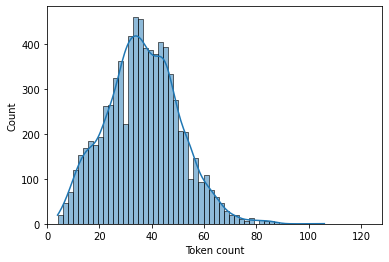

In [43]:
import matplotlib.pyplot as plt
sns.histplot(token_lens, kde = True)
plt.xlim([0,128]);
plt.xlabel('Token count');

To be on the safe side, we'll do a max length of 128.

We'll need to make our dataset

In [44]:
class TextDataset(Dataset):
  def __init__(self,texts,targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  # We need to define a __getitem__ function that will get an item from an iterable object (texts in this case)
  def __getitem__(self,item):
    text = str(self.texts[item])
    target = self.targets[item]

    # Adding special tokens is necessary, since BERT needs the tokens to have special markers:
    # [CLS] for start of token list (sentence), [SEP] for end of token list (sentence), [PAD] for the padding

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'longest',
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype = torch.long)
    }



In [45]:
X = train_data['text']
y = train_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [46]:
X_train.shape, y_train.shape

((6090,), (6090,))

In [47]:
import os
BATCH_SIZE = 16
MAX_LEN = 128

train_dataset = TextDataset(texts = X_train.to_numpy(), 
                            targets = y_train.to_numpy(), 
                            tokenizer = tokenizer, 
                            max_len = MAX_LEN)

test_dataset = TextDataset(texts = X_test.to_numpy(), targets = y_test.to_numpy(), tokenizer = tokenizer, 
                           max_len = MAX_LEN)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 1,
                              num_workers = os.cpu_count(),
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1, 
                             num_workers = os.cpu_count(),
                             shuffle = False)

In [48]:
data = next(iter(train_dataloader))

In [49]:
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [50]:
data['input_ids'].shape, data['attention_mask'].shape, data['targets'].shape

(torch.Size([1, 50]), torch.Size([1, 50]), torch.Size([1]))

In [51]:
bert_model = BertModel.from_pretrained(BERT_PRETRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
# Adding return_dict = False to avoid the Dropout argument must be Tensor error (issue with Transformers v3 and v4)
class DisasterClassifier(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_PRETRAINED_MODEL_NAME, return_dict = False)
    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    a, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [53]:
model = DisasterClassifier(n_classes = 2)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DisasterClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

Changed LR from 2e-5 to 1e-5, and changed the Dropout p to 0.2 from 0.3 in the classifier.

LR = 2e-5 with Dropout 0.3 ====> 81.58% Test accuracy | 95.31% Train accuracy

LR = 1e-5 with Dropout 0.2 ====> 43% Test | 44% Train accuracy

LR = 2e-5 with Dropout 0.2 ====> 76% Test | 78% Train

LR = 3e-5 with Dropout 0.25 ====> 42% Test | 42% Train

LR = 3e-5 with Dropout 0.3 ====> 57% Test | 57% Train

LR = 2e-5 with Dropout 0.25 ===> 75% Test | 81% Train

In [54]:
EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
total_steps = len(train_dataloader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [55]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model.train()

  losses = []
  correct_pred = 0

  for data in data_loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)


    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask).squeeze()
    
    preds = torch.argmax(outputs, dim = -1).flatten()

    loss = loss_fn(outputs, targets[0])

    optimizer.zero_grad()

    correct_pred += torch.sum(preds == targets[0])
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

  return correct_pred / n_examples, np.mean(losses)

In [56]:
def eval(model, data_loader, loss_fn, optimizer, device, n_examples):
  model.eval()

  losses = []
  correct_pred = 0

  with torch.inference_mode():
    for data in data_loader:
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      outputs = model(input_ids = input_ids,
                      attention_mask = attention_mask).squeeze()
      
      preds = torch.argmax(outputs, dim = -1).flatten()

      loss = loss_fn(outputs, targets[0])

      correct_pred += torch.sum(preds == targets[0])
      losses.append(loss.item())

  return correct_pred / n_examples, np.mean(losses)

In [57]:
from timeit import default_timer as timer
from collections import defaultdict

start_time = timer()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(4):
  print(f"Epoch {epoch +1} ")
  print("**"*20)
  train_acc, train_loss = train(model, train_dataloader,
                                loss_fn,
                                optimizer,
                                device,
                                scheduler,
                                len(X_train))
  
  print(f'Train loss {train_loss} | Train accuracy {train_acc}')

  test_acc, test_loss = eval(model,
                             test_dataloader,
                             loss_fn,
                             optimizer,
                             device,
                             len(X_test))
  
  print(f'Val   loss {test_loss} | Test accuracy {test_acc}')


  history['train_loss'].append(train_loss)
  history['test_loss'].append(test_loss)


Epoch 1 
****************************************
Train loss 1.052265503015588 | Train accuracy 0.7829228043556213
Val   loss 0.9228240598617788 | Test accuracy 0.8148391246795654
Epoch 2 
****************************************
Train loss 0.8592444672441276 | Train accuracy 0.840886652469635
Val   loss 1.221875963774947 | Test accuracy 0.7793828248977661
Epoch 3 
****************************************
Train loss 0.7691197583664554 | Train accuracy 0.8637109994888306
Val   loss 1.1331142586073761 | Test accuracy 0.8082731366157532
Epoch 4 
****************************************
Train loss 0.6922213300274104 | Train accuracy 0.8771756887435913
Val   loss 1.1398459018905356 | Test accuracy 0.8122127652168274
